In [162]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [14]:
# extract age and gender labels embedded in the filename
images = []
age = []
gender = []
basepath = Path(r'C:\Users\admin\Downloads\crop_part1\crop_part1')
files_in_basepath = basepath.iterdir()
for item in files_in_basepath:
    if item.is_file():
        img = Image.open(item)
        img = ImageOps.grayscale(img)
        img = img.resize((128,128))
        img1 = np.array(img)
        images.append(img1)
        item = str(item)
        item = item.split('_')
        age.append(item[2].split('\\')[1])
        gender.append(item[3])

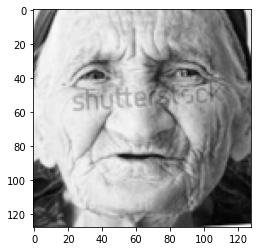

In [102]:
plt.imshow(images[0], cmap = 'gray')

In [16]:
age[0:10]

['100', '100', '101', '10', '10', '10', '10', '10', '10', '10']

In [17]:
gender[0:10]        # 0-Male and 1-Female

['1', '1', '1', '0', '0', '0', '0', '0', '0', '0']

In [18]:
print(np.shape(images))
print(np.shape(gender))
print(np.shape(age))

(9780, 128, 128)
(9780,)
(9780,)


In [19]:
# convert values from string to integer
age = list(map(int, age))
gender = list(map(int, gender))

(array([4.372e+03, 0.000e+00, 0.000e+00, 5.407e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

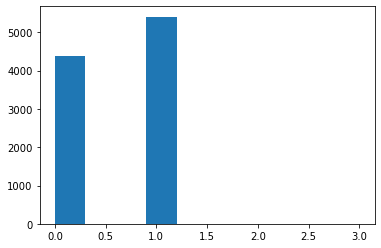

In [20]:
plt.hist(gender) 

We can observe from above cell that we have 1 wrong entry in the dataset, which needs to be removed.

In [22]:
data = pd.DataFrame({
    'image': images,
    'gender': gender,
    'age': age })
print(np.shape(data))
data.head()

(9780, 3)


,image,gender,age
0,"[[230, 235, 235, 228, 154, 118, 113, 112, 130,...",1,100
1,"[[43, 40, 37, 35, 34, 36, 37, 38, 40, 41, 40, ...",1,100
2,"[[220, 220, 221, 221, 222, 222, 222, 221, 220,...",1,101
3,"[[84, 78, 82, 78, 69, 71, 70, 63, 58, 49, 41, ...",0,10
4,"[[41, 81, 83, 74, 84, 67, 61, 79, 75, 79, 84, ...",0,10


In [23]:
# remove incorrect entries
data = data[data.gender != 3]
np.shape(data)

(9779, 3)

In [24]:
# Normalize values of image 
data.image = data.image/255.0

In [25]:
# Normalize age column
min_max = MinMaxScaler()
data.age = min_max.fit_transform(np.array(data.age).reshape(-1,1))

In [457]:
# split data into training and testing set
train, test = train_test_split(data, test_size=0.2, random_state = 100)   

# split training data into training and validation set
train, val = train_test_split(train, test_size=0.1, random_state = 100)

In [458]:
# convert images in a format acceptable by the model
img_train = []
img_train = train.image.values
train_images = np.zeros((train.image.shape[0], 128, 128), dtype = 'float32')
for i in range(train.image.shape[0]):
    train_images[i] = img_train[i]
    
img_val = []
img_val = val.image.values
val_images = np.zeros((val.image.shape[0], 128, 128), dtype = 'float32')
for i in range(val.image.shape[0]):
    val_images[i] = img_val[i]
    
img_test = []
img_test = test.image.values
test_images = np.zeros((test.image.shape[0], 128, 128), dtype = 'float32')
for i in range(test.image.shape[0]):
    test_images[i] = img_test[i]

In [459]:
print('Train data shape - ', np.shape(train))
print('Validation data shape - ', np.shape(val))
print('Test data shape - ', np.shape(test))

Train data shape -  (7040, 3)
Validation data shape -  (783, 3)
Test data shape -  (1956, 3)


In [460]:
# reshape datasets in - (number of images, 128, 128, 1)
train_images = np.reshape(train_images, (train_images.shape[0], train_images.shape[1], train_images.shape[2], 1))
val_images = np.reshape(val_images, (val_images.shape[0], val_images.shape[1], val_images.shape[2], 1))
test_images = np.reshape(test_images, (test_images.shape[0], test_images.shape[1], test_images.shape[2], 1))

In [520]:
# make our models using TensorFlow 
model_input = tf.keras.Input(shape = (128,128,1))
conv1 = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=(128,128,1),activation='relu', padding = 'same')(model_input)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu')(pool3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv4)
drop1 = tf.keras.layers.Dropout(0.2)(pool4)
flat = tf.keras.layers.Flatten()(drop1)

age_model = tf.keras.layers.Dense(64, activation = 'relu')(flat)
age_model = tf.keras.layers.Dropout(0.2)(age_model)
age_model = tf.keras.layers.Dense(32, activation = 'relu')(age_model)
age_model = tf.keras.layers.Dense(1, activation = 'sigmoid')(age_model)

gender_model = tf.keras.layers.Dense(64, activation = 'relu')(flat)
gender_model = tf.keras.layers.Dropout(0.2)(gender_model)
gender_model = tf.keras.layers.Dense(32, activation = 'relu')(gender_model)
gender_model = tf.keras.layers.Dropout(0.2)(gender_model)
gender_model = tf.keras.layers.Dense(1, activation = 'sigmoid')(gender_model)

In [521]:
model = tf.keras.Model(inputs=model_input, outputs=[age_model,gender_model])  # combine the age and gender model 
adam = tf.keras.optimizers.Adam()
model.compile(optimizer = adam, loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [522]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 128, 128, 32) 320         input_33[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_119 (MaxPooling2D (None, 64, 64, 32)   0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 62, 62, 64)   18496       max_pooling2d_119[0][0]          
___________________________________________________________________________________________

In [523]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience = 3, restore_best_weights=True)   

# train model
history = model.fit(train_images, [train.age, train.gender], 
                    epochs=30, batch_size = 64, validation_data = (val_images, [val.age, val.gender]), callbacks=[early_stopping],
                    verbose=1)

Epoch 1/30
110/110 [==============================] - 187s 2s/step - loss: 0.7336 - dense_202_loss: 0.0565 - dense_205_loss: 0.6770 - dense_202_accuracy: 0.1070 - dense_205_accuracy: 0.5629 - val_loss: 0.6001 - val_dense_202_loss: 0.0304 - val_dense_205_loss: 0.5697 - val_dense_202_accuracy: 0.1098 - val_dense_205_accuracy: 0.6858
Epoch 2/30
110/110 [==============================] - 172s 2s/step - loss: 0.6124 - dense_202_loss: 0.0302 - dense_205_loss: 0.5821 - dense_202_accuracy: 0.1168 - dense_205_accuracy: 0.6937 - val_loss: 0.5398 - val_dense_202_loss: 0.0244 - val_dense_205_loss: 0.5154 - val_dense_202_accuracy: 0.1111 - val_dense_205_accuracy: 0.7433
Epoch 3/30
110/110 [==============================] - 159s 1s/step - loss: 0.5357 - dense_202_loss: 0.0240 - dense_205_loss: 0.5117 - dense_202_accuracy: 0.1206 - dense_205_accuracy: 0.7386 - val_loss: 0.5052 - val_dense_202_loss: 0.0277 - val_dense_205_loss: 0.4774 - val_dense_202_accuracy: 0.1098 - val_dense_205_accuracy: 0.7663
E

In [524]:
# store the history of the model in a dataframe
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,dense_202_loss,dense_205_loss,dense_202_accuracy,dense_205_accuracy,val_loss,val_dense_202_loss,val_dense_205_loss,val_dense_202_accuracy,val_dense_205_accuracy
0,0.696715,0.045526,0.651190,0.114063,0.602557,0.600081,0.030370,0.569711,0.109834,0.685824
1,0.596428,0.027929,0.568499,0.116051,0.704545,0.539822,0.024381,0.515440,0.111111,0.743295
2,0.523169,0.022906,0.500263,0.115909,0.746733,0.505162,0.027727,0.477435,0.109834,0.766284
3,0.462732,0.021161,0.441571,0.116193,0.787500,0.397903,0.020673,0.377230,0.109834,0.819923
4,0.426242,0.018219,0.408023,0.116051,0.799716,0.384126,0.017454,0.366673,0.109834,0.814815


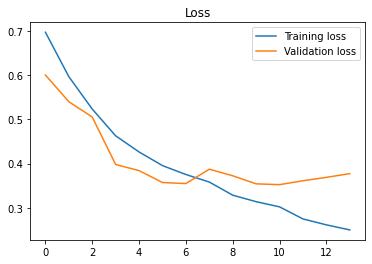

In [525]:
# plotting training and validation loss
plt.title('Loss')
plt.plot(history_df['loss'], label = 'Training loss')
plt.plot(history_df['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [526]:
#Predictions
pred = model.predict(test_images)
pred_age = pred[0]
pred_gender = pred[1]

In [527]:
# Convert age (predictions and testing data) in readable form
pred_age = min_max.inverse_transform(np.array(pred_age).reshape(-1,1))
pred_age = np.round(pred_age, decimals = 0)

actual_age = np.zeros((1956,1))
actual_age = min_max.inverse_transform(np.array(test.age.values).reshape(-1,1))
actual_age = np.round(actual_age, decimals = 0)

In [528]:
# Convert gender (predictions and testing data) in readable form
pred_gender = np.round(pred_gender, decimals = 0)
pred_gender_str = []
for i in range (pred_gender.shape[0]):
    if (pred_gender[i] == 0.0):
        pred_gender_str.append('Male')
    else:
        pred_gender_str.append('Female')
        
actual_gender_str = []
for i in range (pred_gender.shape[0]):
    if (test.gender.values[i] == 0):
        actual_gender_str.append('Male')
    else:
        actual_gender_str.append('Female')

Predicted age:  15
Actual age: 22
Predicted gender:  Male
Actual gender: Male


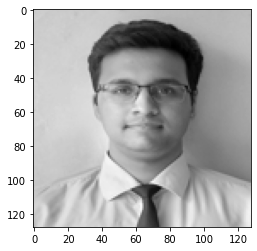

In [529]:
# prediction results on my image
img = Image.open(r'C:\Users\admin\Downloads\My_Image.jpg')
img = ImageOps.grayscale(img)
img = img.resize((128,128))
plt.imshow(img, cmap = 'gray')

img1 = np.array(img)
img1 = img1/255.0
image_list = []               # Necessary to store it in a list to obtain a shape of desired by the model, that is - (None, 128, 128, 1)
image_list.append(img1)
x = np.asarray(image_list)

my_pred = model.predict(x)
my_pred_age = my_pred[0]
my_pred_gender = my_pred[1]
my_pred_age = min_max.inverse_transform(np.array(my_pred_age).reshape(-1,1))
my_pred_age = int(np.round(my_pred_age, decimals = 0))
my_pred_gender = int(np.round(my_pred_gender, decimals = 0))
my_pred_gender_str = ""
if (my_pred_gender == 0.0):
    my_pred_gender_str = 'Male'
else:
    my_pred_gender_str = 'Female'
    
print('Predicted age: ', my_pred_age)
print('Actual age: 22')
print('Predicted gender: ', my_pred_gender_str)
print('Actual gender: Male')

We know that the model has performed well if it is able to estimate the approximate age. So, to understand the accuracy of the model for age estimation, we will consider a factor of +- 7 years for approximation.

In [530]:
# Accuracy of model on age prediction. 
approximation = 7
count = 0
for i in range(pred_age.shape[0]):
    if ((pred_age[i] >= (actual_age[i] - approximation)) and (pred_age[i] <= (actual_age[i] + approximation))):
        count = count + 1
    else:
        continue
age_accuracy = (count/pred_age.shape[0])*100
print('Age accuracy', age_accuracy, '%')

Age accuracy 58.79345603271984 %


In [531]:
# Accuracy of model on gender prediction
gender_accuracy = accuracy_score(pred_gender, test.gender.values)
print("Gender accuracy - ", (gender_accuracy*100), '%')

Gender accuracy -  83.99795501022494 %
